In [1]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from torch_geometric.data import Data
from scipy.sparse import coo_matrix
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
import torch.nn.functional as F
from torch_geometric.nn import NNConv, GCNConv, global_mean_pool

# Visualization
import matplotlib.pyplot as plt
import os

In [2]:
output_folder_path = f"/home/schivilkar/dev/final_video_processing/DataSummary/Path1/"
output_file_path = os.path.join(output_folder_path, "Path1_All_Sessions.csv")
combined_data = pd.read_csv(output_file_path)
print(combined_data.columns)
# Filter out rows where time is not between 7 AM and 7 PM
# Ensure 'timestamp' is a datetime object
combined_data['timestamp'] = pd.to_datetime(combined_data['timestamp'])

# Filtering out rows between 7 PM (19:00) to 7 AM (07:00)
combined_data = combined_data[
    (combined_data['timestamp'].dt.hour >= 7) & (combined_data['timestamp'].dt.hour < 19)
]

print(combined_data.shape)
# Ensure the timestamp column is in datetime format
combined_data['timestamp'] = pd.to_datetime(combined_data['timestamp'])
combined_data['hour'] = combined_data['timestamp'].dt.hour
combined_data['day_of_week'] = combined_data['timestamp'].dt.dayofweek

combined_data.head()
df = combined_data

Index(['timestamp', 'recorder1_9m', 'recorder2_9m', 'A_to_B', 'B_to_A',
       'Total_A_to_B', 'Total_B_to_A', 'recorder1_9m_b', 'recorder2_9m_b',
       'recorder3_9m_b', 'recorder1_9m_c', 'recorder2_9m_c'],
      dtype='object')
(284340, 12)


In [3]:
# Check for nulls and basic info
print("Null Summary:\n", df.isnull().sum())
print("\nData Types:\n", df.dtypes)

# Optional: Fill missing values if needed
df.fillna(0, inplace=True)


Null Summary:
 timestamp           0
recorder1_9m        0
recorder2_9m        0
A_to_B              0
B_to_A              0
Total_A_to_B        0
Total_B_to_A        0
recorder1_9m_b      0
recorder2_9m_b      0
recorder3_9m_b      0
recorder1_9m_c    275
recorder2_9m_c    275
hour                0
day_of_week         0
dtype: int64

Data Types:
 timestamp         datetime64[ns]
recorder1_9m               int64
recorder2_9m               int64
A_to_B                     int64
B_to_A                     int64
Total_A_to_B               int64
Total_B_to_A               int64
recorder1_9m_b           float64
recorder2_9m_b           float64
recorder3_9m_b           float64
recorder1_9m_c           float64
recorder2_9m_c           float64
hour                       int32
day_of_week                int32
dtype: object


In [7]:
# General statistics
summary = df.describe()
print("Summary Stats:\n", summary)

# Grouped mean by timestamp (if needed)
grouped_means = df.groupby(df['timestamp']).mean()
print("\nGrouped Means:\n", grouped_means)


Summary Stats:
                            timestamp   recorder1_9m   recorder2_9m  \
count                         284340  284340.000000  284340.000000   
mean   2024-07-01 04:18:05.101382912       1.419399       1.457628   
min              2024-02-15 12:30:23       0.000000       0.000000   
25%    2024-02-29 13:04:33.750000128       0.000000       0.000000   
50%       2024-10-22 12:09:29.500000       1.000000       1.000000   
75%    2024-10-29 11:15:14.249999872       2.000000       2.000000   
max              2024-10-30 18:59:59      16.000000      24.000000   
std                              NaN       1.914073       2.391611   

              A_to_B         B_to_A   Total_A_to_B   Total_B_to_A  \
count  284340.000000  284340.000000  284340.000000  284340.000000   
mean        0.025885       0.005282     182.037262      34.567426   
min         0.000000       0.000000       0.000000       0.000000   
25%         0.000000       0.000000      41.000000       8.000000   
50%     

In [4]:
# Sample DataFrame creation
# Assuming 'timestamp' is a column with datetime data on second intervals
combined_data['timestamp'] = pd.date_range(start='2024-02-15 12:30:23', periods=len(combined_data), freq='S')
combined_data.set_index('timestamp', inplace=True)

# Define custom aggregation functions for each column
aggregations = {
    'recorder1_9m': 'mean',  # Replace 'location1' to 'location6' with your actual column names
    'recorder2_9m': 'mean',
    'recorder1_9m_b': 'mean',
    'recorder2_9m_b': 'mean',
    'recorder3_9m_b': 'mean',
    'recorder1_9m_c': 'mean',
    'recorder2_9m_c': 'mean',
    'hour': 'first',
    'day_of_week': 'first',
    'A_to_B': 'sum',
    'B_to_A': 'sum',
    'Total_A_to_B': 'mean',
    'Total_B_to_A': 'mean'
}

# Resample and compute the mean for each 5-second interval
aggregated_data_2s = combined_data.resample('2S').agg(aggregations)
aggregated_data_3s = combined_data.resample('3S').agg(aggregations)
aggregated_data_5s = combined_data.resample('5S').agg(aggregations)
aggregated_data_10s = combined_data.resample('10S').agg(aggregations)

# Reset the index if you want 'timestamp' back as a column
aggregated_data_2s.reset_index(inplace=True)
aggregated_data_3s.reset_index(inplace=True)
aggregated_data_5s.reset_index(inplace=True)
aggregated_data_10s.reset_index(inplace=True)

# Now, aggregated_data holds the averaged values for each 5-second chunk
aggregated_data_2s.head()

,timestamp,recorder1_9m,recorder2_9m,recorder1_9m_b,recorder2_9m_b,recorder3_9m_b,recorder1_9m_c,recorder2_9m_c,hour,day_of_week,A_to_B,B_to_A,Total_A_to_B,Total_B_to_A
0,2024-02-15 12:30:22,0.0,0.0,4.0,7.0,6.0,3.0,5.0,12,3,0,0,0.0,0.0
1,2024-02-15 12:30:24,0.0,0.5,2.5,7.5,6.0,3.0,4.5,12,3,0,0,0.0,0.0
2,2024-02-15 12:30:26,0.0,0.0,2.0,8.5,7.5,3.0,3.0,12,3,0,0,0.0,0.0
3,2024-02-15 12:30:28,3.5,0.0,3.5,5.5,7.5,3.5,3.5,12,3,0,0,0.0,0.0
4,2024-02-15 12:30:30,0.0,0.0,4.5,7.0,6.5,3.5,3.0,12,3,0,0,0.0,0.0


In [5]:
aggregated_data_5s.shape

(56869, 14)

In [ ]:
aggregated_data_5s['timestamp'] = pd.to_datetime(aggregated_data_5s['timestamp'])
aggregated_data_5s.set_index('timestamp', inplace=True)


In [7]:
# Sum over each hour
hourly_data = aggregated_data_5s.resample('H').sum()
hourly_data.head()


,recorder1_9m,recorder2_9m,recorder1_9m_b,recorder2_9m_b,recorder3_9m_b,recorder1_9m_c,recorder2_9m_c,hour,day_of_week,A_to_B,B_to_A,Total_A_to_B,Total_B_to_A
timestamp,,,,,,,,,,,,,
2024-02-15 12:00:00,768.8,292.9,542.1,2415.8,844.2,909.6,864.2,4272,1068,39,13,6727.0,2032.4
2024-02-15 13:00:00,2134.6,1043.0,1569.4,5494.0,2577.8,2681.8,3047.6,9360,2160,125,32,56315.8,16771.0
2024-02-15 14:00:00,3105.0,675.0,1069.0,3266.6,1597.0,1876.6,1779.8,10080,2160,91,23,149788.2,40956.0
2024-02-15 15:00:00,2818.6,1161.0,1591.0,5883.2,1702.6,2718.4,3613.4,10800,2160,180,23,268052.2,57953.6
2024-02-15 16:00:00,1835.0,824.8,1482.0,5591.0,1326.6,2445.0,2557.8,11520,2160,85,51,310247.2,71427.2


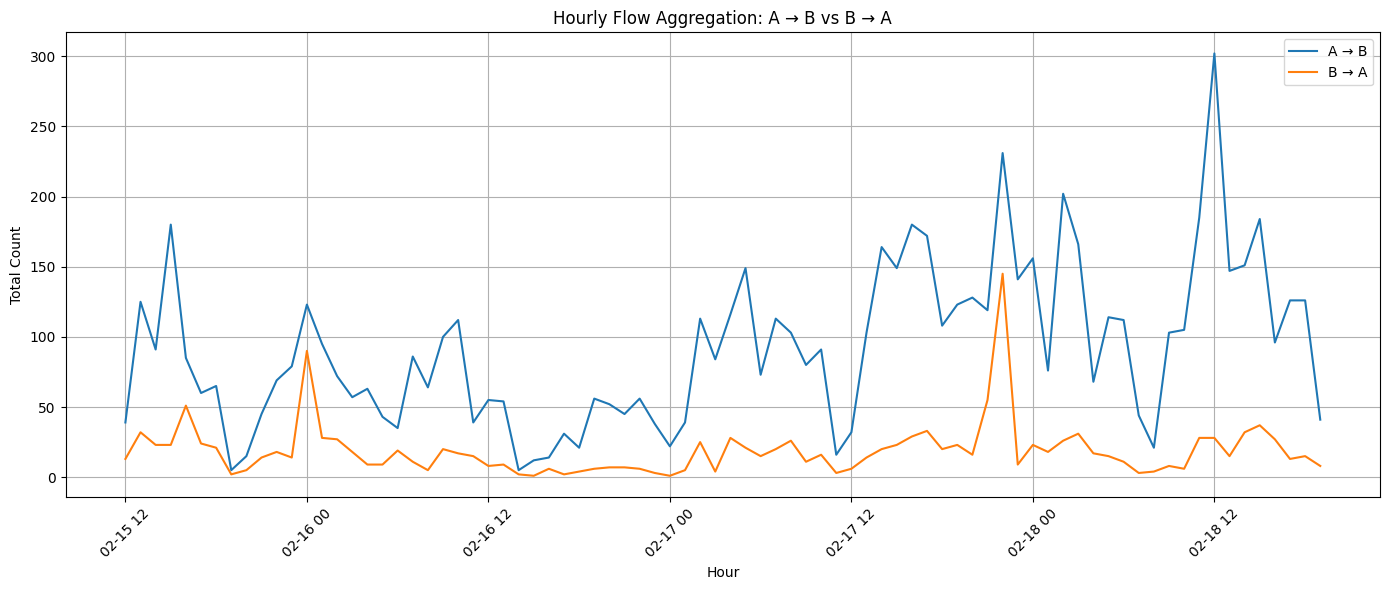

In [8]:
import matplotlib.pyplot as plt

plt.figure(figsize=(14, 6))
plt.plot(hourly_data.index, hourly_data['A_to_B'], label='A → B')
plt.plot(hourly_data.index, hourly_data['B_to_A'], label='B → A')
plt.title("Hourly Flow Aggregation: A → B vs B → A")
plt.xlabel("Hour")
plt.ylabel("Total Count")
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


In [15]:
import pandas as pd

# Load your DataFrame (skip this if already loaded)
output_folder_path = f"/home/schivilkar/dev/final_video_processing/DataSummary/Path1/"
output_file_path = os.path.join(output_folder_path, "Path1_All_Sessions.csv")

df = pd.read_csv(output_file_path)

# Convert 'timestamp' to datetime
df['timestamp'] = pd.to_datetime(df['timestamp'])

# Extract date part and count unique dates
unique_date_count = df['timestamp'].dt.date.unique()
print(f"Number of unique dates: {unique_date_count}")


Number of unique dates: [datetime.date(2024, 2, 15) datetime.date(2024, 2, 16)
 datetime.date(2024, 2, 17) datetime.date(2024, 2, 29)
 datetime.date(2024, 3, 1) datetime.date(2024, 3, 2)
 datetime.date(2024, 10, 22) datetime.date(2024, 10, 23)
 datetime.date(2024, 10, 24) datetime.date(2024, 10, 29)
 datetime.date(2024, 10, 30) datetime.date(2024, 10, 31)]


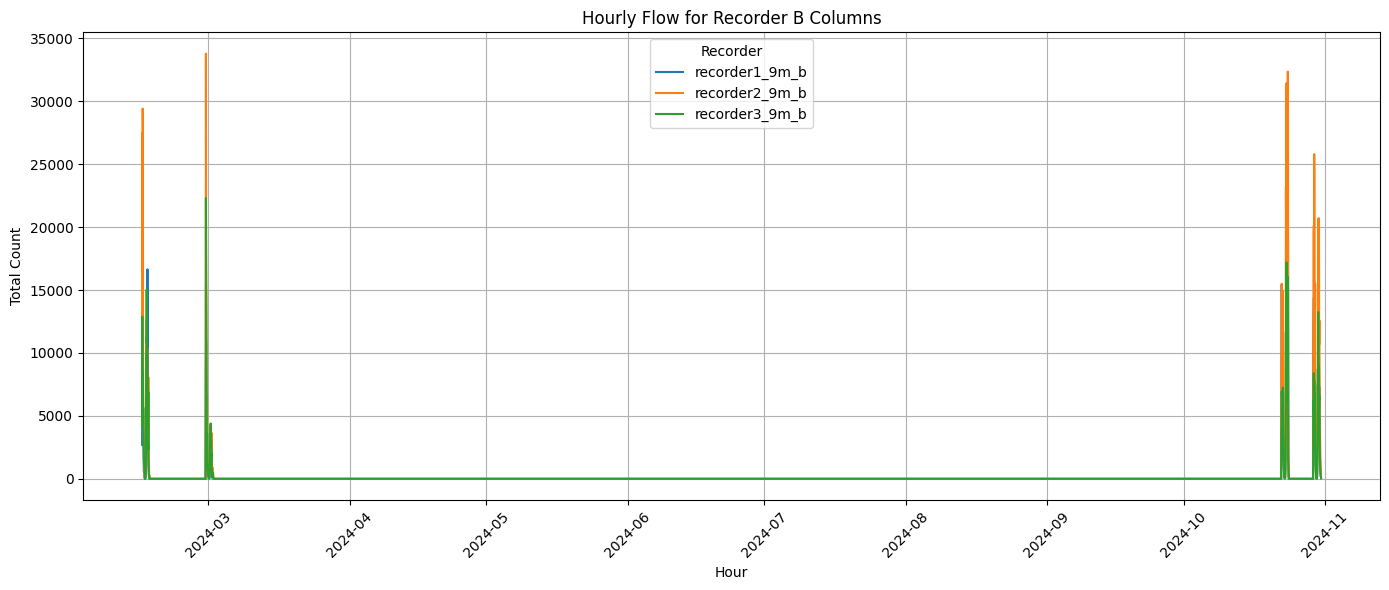

In [16]:
import pandas as pd
import matplotlib.pyplot as plt

# Assuming df is your original 5s-level DataFrame
df['timestamp'] = pd.to_datetime(df['timestamp'])
df.set_index('timestamp', inplace=True)

# Select only the recorder_b columns
recorder_b_cols = [col for col in df.columns if 'recorder' in col and '_b' in col]

# Resample to hourly and sum
hourly_recorders_b = df[recorder_b_cols].resample('H').sum()

# Plot
plt.figure(figsize=(14, 6))
for col in recorder_b_cols:
    plt.plot(hourly_recorders_b.index, hourly_recorders_b[col], label=col)

plt.title("Hourly Flow for Recorder B Columns")
plt.xlabel("Hour")
plt.ylabel("Total Count")
plt.legend(title="Recorder")
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


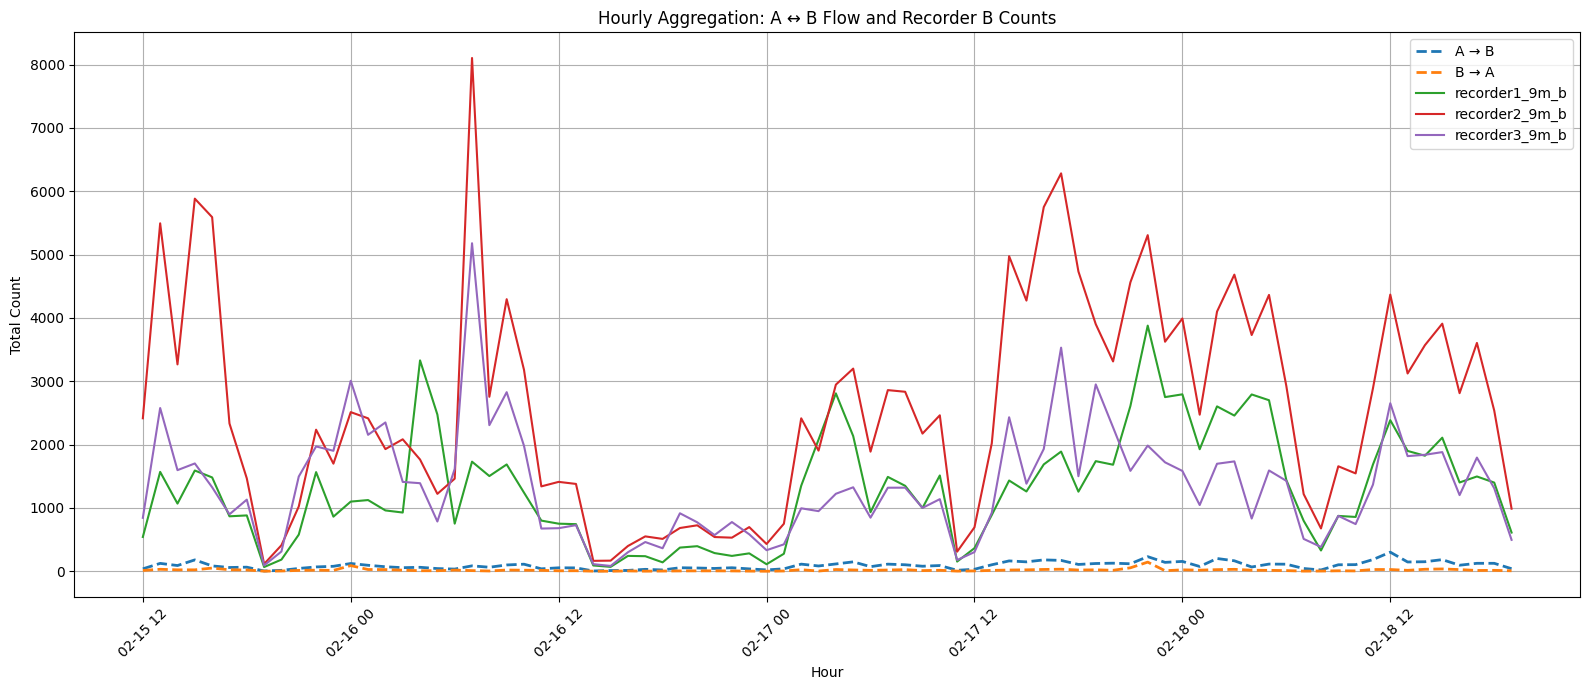

In [18]:
import matplotlib.pyplot as plt

# List of recorder_b columns
recorder_b_cols = [col for col in hourly_data.columns if 'recorder' in col and '_b' in col]

# Plotting
plt.figure(figsize=(16, 7))

# Plot directional flows first
plt.plot(hourly_data.index, hourly_data['A_to_B'], label='A → B', linestyle='--', linewidth=2)
plt.plot(hourly_data.index, hourly_data['B_to_A'], label='B → A', linestyle='--', linewidth=2)

# Plot recorder_b flows
for col in recorder_b_cols:
    plt.plot(hourly_data.index, hourly_data[col], label=col)

# Styling
plt.title("Hourly Aggregation: A ↔ B Flow and Recorder B Counts")
plt.xlabel("Hour")
plt.ylabel("Total Count")
plt.legend(loc='upper right')
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


In [19]:
# Get only the relevant columns from the hourly_data DataFrame
flow_cols = ['A_to_B', 'B_to_A']
recorder_b_cols = [col for col in hourly_data.columns if 'recorder' in col and '_b' in col]

# Combine for correlation check
correlation_df = hourly_data[flow_cols + recorder_b_cols]


In [20]:
correlation_matrix = correlation_df.corr()
print(correlation_matrix)


                  A_to_B    B_to_A  recorder1_9m_b  recorder2_9m_b  \
A_to_B          1.000000  0.563124        0.710581        0.754806   
B_to_A          0.563124  1.000000        0.525494        0.506208   
recorder1_9m_b  0.710581  0.525494        1.000000        0.686770   
recorder2_9m_b  0.754806  0.506208        0.686770        1.000000   
recorder3_9m_b  0.597611  0.418804        0.505992        0.790037   

                recorder3_9m_b  
A_to_B                0.597611  
B_to_A                0.418804  
recorder1_9m_b        0.505992  
recorder2_9m_b        0.790037  
recorder3_9m_b        1.000000  


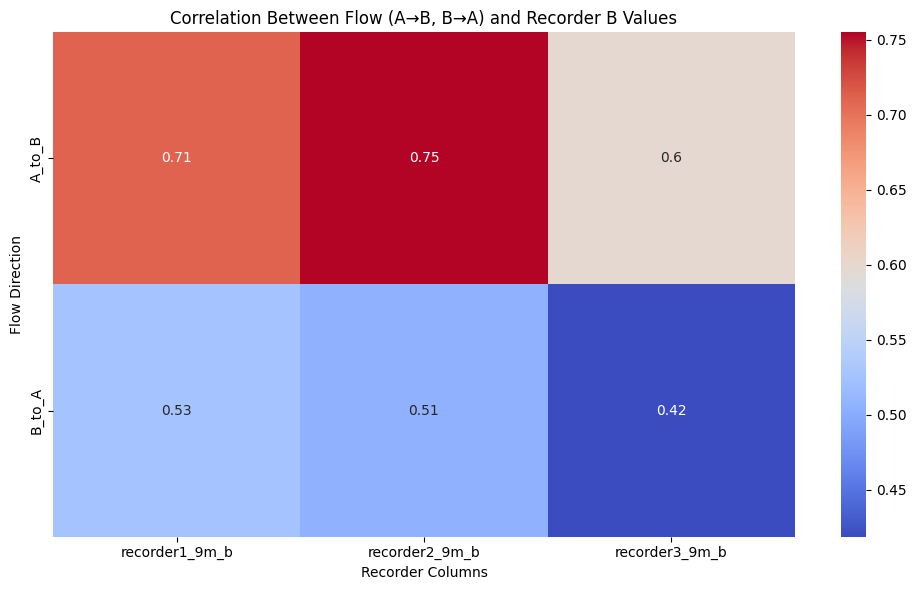

In [21]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
sns.heatmap(correlation_matrix.loc[flow_cols, recorder_b_cols], annot=True, cmap='coolwarm')
plt.title("Correlation Between Flow (A→B, B→A) and Recorder B Values")
plt.xlabel("Recorder Columns")
plt.ylabel("Flow Direction")
plt.tight_layout()
plt.show()


In [22]:
# Get only the relevant columns from the hourly_data DataFrame
flow_cols = ['A_to_B', 'B_to_A']
recorder_c_cols = [col for col in hourly_data.columns if 'recorder' in col and '_c' in col]

# Combine for correlation check
correlation_df = hourly_data[flow_cols + recorder_c_cols]


In [23]:
correlation_matrix = correlation_df.corr()
print(correlation_matrix)


                  A_to_B    B_to_A  recorder1_9m_c  recorder2_9m_c
A_to_B          1.000000  0.563124        0.582368        0.735171
B_to_A          0.563124  1.000000        0.471106        0.655518
recorder1_9m_c  0.582368  0.471106        1.000000        0.640534
recorder2_9m_c  0.735171  0.655518        0.640534        1.000000


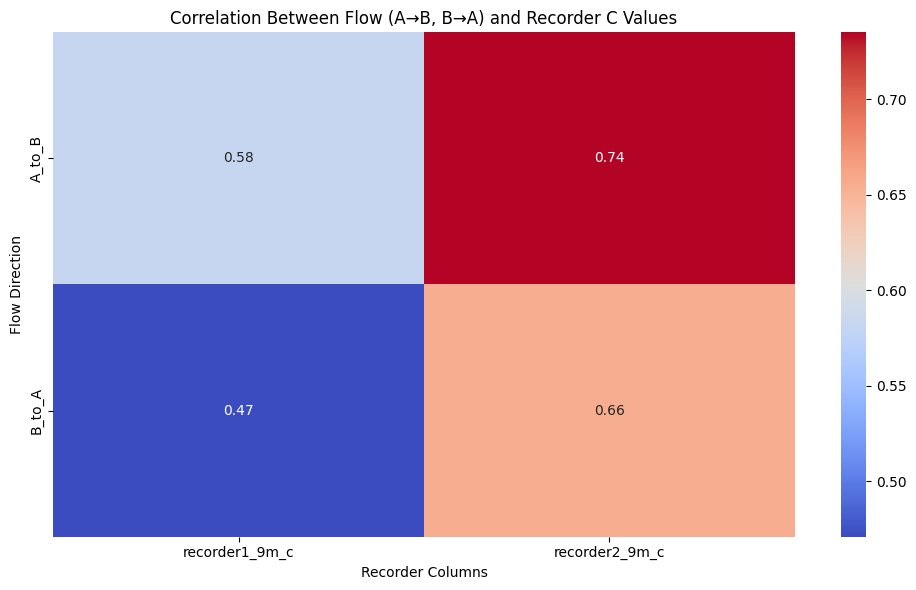

In [24]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
sns.heatmap(correlation_matrix.loc[flow_cols, recorder_c_cols], annot=True, cmap='coolwarm')
plt.title("Correlation Between Flow (A→B, B→A) and Recorder C Values")
plt.xlabel("Recorder Columns")
plt.ylabel("Flow Direction")
plt.tight_layout()
plt.show()


In [25]:
# Get only the relevant columns from the hourly_data DataFrame
flow_cols = ['A_to_B', 'B_to_A']
recorder_p1_cols = [col for col in hourly_data.columns if 'recorder' in col and not '_c' in col and not '_b' in col]

# Combine for correlation check
correlation_df = hourly_data[flow_cols + recorder_p1_cols]


                A_to_B    B_to_A  recorder1_9m  recorder2_9m
A_to_B        1.000000  0.563124      0.394016      0.665272
B_to_A        0.563124  1.000000      0.358936      0.903601
recorder1_9m  0.394016  0.358936      1.000000      0.295610
recorder2_9m  0.665272  0.903601      0.295610      1.000000


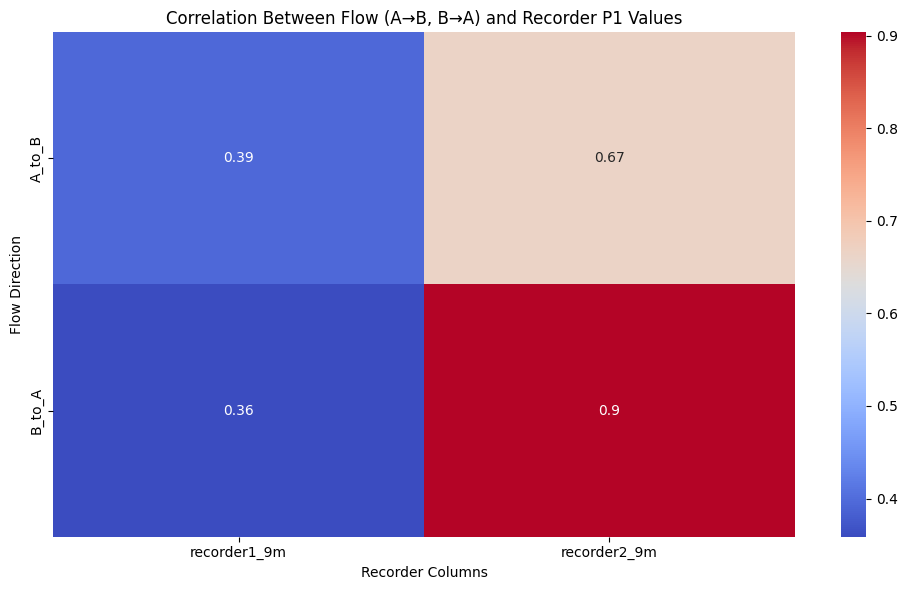

In [26]:
correlation_matrix = correlation_df.corr()
print(correlation_matrix)


plt.figure(figsize=(10, 6))
sns.heatmap(correlation_matrix.loc[flow_cols, recorder_p1_cols], annot=True, cmap='coolwarm')
plt.title("Correlation Between Flow (A→B, B→A) and Recorder P1 Values")
plt.xlabel("Recorder Columns")
plt.ylabel("Flow Direction")
plt.tight_layout()
plt.show()